## 1. 데이터 로드하기

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import fetch_openml

In [4]:
mnist = fetch_openml('mnist_784',version=1,cache=True)

In [20]:
mnist.data.iloc[0,:]

pixel1      0.0
pixel2      0.0
pixel3      0.0
pixel4      0.0
pixel5      0.0
           ... 
pixel780    0.0
pixel781    0.0
pixel782    0.0
pixel783    0.0
pixel784    0.0
Name: 0, Length: 784, dtype: float64

In [16]:
mnist.target[0]

'5'

In [21]:
mnist.target = mnist.target.astype(np.int8)

In [23]:
X = mnist.data / 255 # 0 ~ 255 값을 0과 1 구간으로 정규화
y = mnist.target

In [31]:
X = np.array(X)

In [35]:
X[0][:200]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

This image's label is 5.


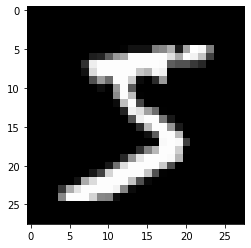

In [39]:
plt.imshow(X[0].reshape(28,28),cmap = 'gray')
print(f"This image's label is {y[0]}.")

## 2. Train & Test split

In [40]:
import torch
from torch.utils.data import TensorDataset,DataLoader
from sklearn.model_selection import train_test_split

X_tr,X_te, y_tr,y_te = train_test_split(torch.Tensor(X),torch.LongTensor(y),test_size=1/7,
                                       random_state=42)

- int형 숫자에서는 longtensor 사용

In [64]:
X_train = TensorDataset(X_tr,y_tr)
X_test = TensorDataset(X_te,y_te)

loader_train = DataLoader(X_train,batch_size=64,shuffle=True)
loader_test = DataLoader(X_test,batch_size=64,shuffle=True)

## 3. 다층 퍼셉트론

In [52]:
from torch import nn,optim

In [65]:
model = nn.Sequential()
model.add_module('fc1',nn.Linear(28*28*1,100))
model.add_module('relu1',nn.ReLU())
model.add_module('fc2',nn.Linear(100,100))
model.add_module('relu2',nn.ReLU())
model.add_module('fc3',nn.Linear(100,10))

print(model)

Sequential(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)


In [66]:
## 오차함수
loss_fn = nn.CrossEntropyLoss() ## 다중분류

## 가중치 최적화 기법
optimizer = optim.Adam(model.parameters(),lr = 0.01)

In [71]:
def train(epoch) :
    for data,targets in loader_train :
        
        optimizer.zero_grad() # 경사 0으로 진행될 때마다 초기화
        outputs = model(data)
        loss = loss_fn(outputs,targets) # 출력과 훈련 데이터 오차 계산
        loss.backward() # 역전파
        optimizer.step() # 역전파 계산한 값으로 가중치 수정
        
    print(f"Epoch{epoch} : 완료\n")

    
def test() :
    model.eval() # 신경망을 추론 모드로 변환
    correct = 0
    
    # 데이터로더에서 미니배치를 하니씩 꺼내 추론 수행
    with torch.no_grad() : # 추론 과정에서는 미분 수행하지 않는다.
        for data, target in loader_test :
            
            outputs = model(data)
            
            # 추론 계산
            _, predicted = torch.max(outputs.data,1) # 확률이 가장 높은 레이블이 무엇인지 계산
            correct += predicted.eq(target.data.view_as(predicted)).sum() # 정답과 일치하면 정답 카운트 증가
            
    # 정확도 출력
    data_num = len(loader_test.dataset)
    print(f"\n테스트 데이터에서 예측 정확도 : {correct}/{data_num} ({100. * correct / data_num}%)\n")

- eval : evaluation 과정에서 사용하지 않아야 하는 layer들을 알아서 off 시키도록 하는 함수, 즉 학습할 때만 필요한 Dropout, Batchnorm 등의 기능을 비활성화시켜준다.
- eq : 각 텐서의 요소(element)들을 비교해 같으면 True를, 다르면 False를 반환

In [72]:
test()


테스트 데이터에서 예측 정확도 : 777/10000 (7.769999980926514%)



In [74]:
for epoch in range(3) :
    train(epoch)
    
test()

Epoch0 : 완료

Epoch1 : 완료

Epoch2 : 완료


테스트 데이터에서 예측 정확도 : 9562/10000 (95.62000274658203%)



예측 결과 : 4
이 이미지 데이터의 정답 레이블은 :9입니다.


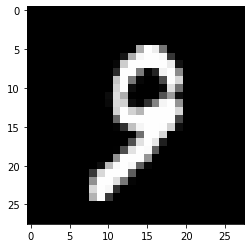

In [84]:
import random

model.eval()
idx = random.randint(0,len(X_test))
data = X_te[idx]
output = model(data)
_,predicted = torch.max(output.data,0)

print(f"예측 결과 : {predicted}")

X_test_show = (X_te[idx]).numpy()
plt.imshow(X_test_show.reshape(28,28),cmap = 'gray')
print(f"이 이미지 데이터의 정답 레이블은 :{y_te[idx]}입니다.")